<a href="https://colab.research.google.com/github/nicolasvazquez95/cursos-python/blob/master/DeepLearning/2_RedesDeUnaCapa/ejercicios/ejercicios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DeepLearning/2_RedesDeUnaCapa/ejercicios/ejercicios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Ejercicios para la clase 2



En este notebook vamos a retomar el ejemplo de la red neuronal entrenada para clasificar FashionMNIST. Si bien ese ejemplo tiene todos los pasos necesarios para entrenar la red, varios de esos pasos sirven para entrenar cualquier otro modelo. Así que vamos a tratar de modularizarlo de manera que el código sea reutilizable.

Arranquemos importando los módulos necesarios.

In [1]:
import torch
import torchvision
from IPython import display
from torchvision import transforms
from torch.utils import data

Volvemos a definir la función que crea los Datasets y devuelve los DataLoaders para poder iterar sobre ellos.

In [2]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))


También definimos una función que devuelve la cantidad de aciertos del modelo a partir de un tensor de predicciones y otro de etiquetas.

In [3]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

Volvemos a definir el modelo con una capa de 10 neuronas para hacer la clasificación e inicializamos sus pesos aleatoriamente con una distribución gaussiana.

In [4]:
net = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(784, 10))

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

Definimos la entropía cruzada como función de perdida y el descenso de gradiente estocástico como algoritmo de optimización. 

In [5]:
loss = torch.nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

Y por último, definimos una función que lleva adelante el entrenamiento completo.

In [6]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
  '''
  Lleva adelante el entrenamiento completo llamando a funciones internas
  que modularizan el ciclo de entrenamiento.

    Parámetros:
            net: la red neuronal que se va a entrenar
            train_iter: iterador de datos de entrenamiento
            test_iter: iterador de datos de prueba
            loss: función de perdida a minimizar
            num_epoch: cantidad de épocas a entrenar
            updater: algoritmo de optimización

    Salida:
            metrics: una lista de tuplas (una para cada epoch)
              con las siguientes componentes
              - epoch: número de época
              - L: pérdida calculada
              - Acc: accuracy de entrenamiento calculada
              - TestAcc: accuracy de prueba calculada
  '''
  metrics =[]
  for epoch in range(num_epochs):
      L, Acc = train_epoch(net, train_iter, loss, updater)
      TestAcc = test_accuracy(net, test_iter)
      metric = (epoch + 1, L, Acc, TestAcc)
      print(metric)
      metrics.append(metric)
  return metrics


## Ejercicio 1

Implementar la función `train_epoch()` que lleva adelante el entrenamiento de una época.

In [14]:
def train_epoch(net, train_iter, loss, updater):
  '''
  Lleva adelante el entrenamiento de una sola época.

    Parámetros:
            net: la red neuronal que se va a entrenar
            train_iter: iterador de datos de entrenamiento
            loss: función de perdida a minimizar
            updater: algoritmo de optimización

    Salida:
            L: pérdida calculada
            Acc: accuracy de entrenamiento calculada
  '''
  L = 0
  N = 0
  Acc = 0
  for X,y in train_iter: # Para cada batch 
    l = loss(net(X),y) 
    trainer.zero_grad() 
    l.mean().backward() # Hace las derivadas de L con respecto a los beta
    trainer.step() # Descenso (un pasito)
    N += l.numel()
    L += float(l.sum())
    Acc += accuracy(net(X),y)
  L = L/N
  Acc = Acc/N
  return L, Acc

## Ejercicio 2

Implementar la función `test_accuracy()` que lleva adelante la evaluación de la performance de la red con los datos de prueba.

In [9]:
def test_accuracy(net, test_iter):
  '''
  Evalúa los resultados del entrenamiento de una sola época.

    Parámetros:
            net: la red neuronal que se va a evaluar
            test_iter: iterador de datos de prueba

    Salida:
            - TestAcc: accuracy de prueba calculada
  '''
  N_test = 0
  TestAcc = 0
  for X_test,y_test in test_iter:
    testacc = accuracy(net(X_test),y_test)
    N_test += y_test.numel()
    TestAcc += testacc
  return TestAcc/N_test

## Ejercicio 3

Utilizar las funciones anteriores para entrenar efectivamente a la red. Entrenarla por 10 epochs y con lotes de tamaño 256.

In [15]:
num_epochs = 10
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
metrics = train(net,train_iter,test_iter,loss,num_epochs,trainer)

(1, 0.4803519349416097, 0.8452166666666666, 0.8232)
(2, 0.4696815460840861, 0.84825, 0.8126)
(3, 0.46240020268758136, 0.85105, 0.8229)
(4, 0.4559072251001994, 0.85285, 0.8239)
(5, 0.4502931200345357, 0.8536333333333334, 0.8305)
(6, 0.4458779023488363, 0.8550166666666666, 0.8282)
(7, 0.441273447227478, 0.8562166666666666, 0.8362)
(8, 0.43755901870727537, 0.8569, 0.8287)
(9, 0.43381372795104983, 0.85815, 0.8355)
(10, 0.43226108328501384, 0.8589333333333333, 0.8272)


In [18]:
import numpy as np
metrics = np.array(metrics)

## Ejercicio 4
Graficar la evolución de los valores de el accuracy de entrenamiento, el accuracy de prueba y la pérdida en función de las épocas.

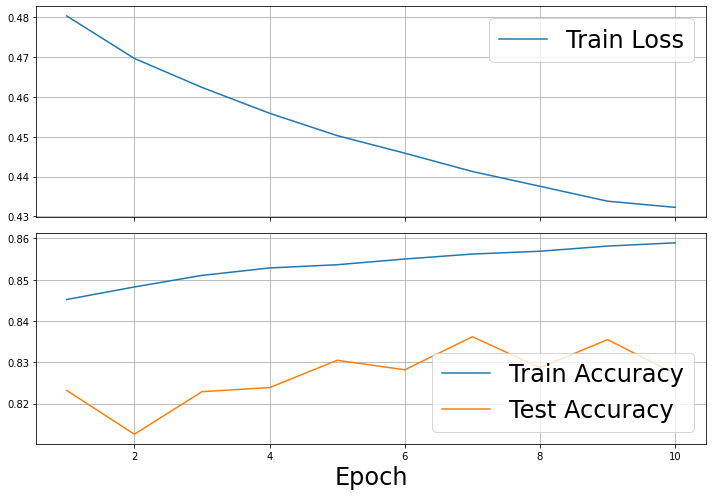

In [26]:
from matplotlib import pyplot as plt
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,7),sharex=True)
ax1.plot(metrics[:,0],metrics[:,1],label='Train Loss')
ax2.plot(metrics[:,0],metrics[:,2],label='Train Accuracy')
ax2.plot(metrics[:,0],metrics[:,3],label='Test Accuracy')
ax1.grid();ax2.grid()
ax2.set_xlabel('Epoch',size=24)
ax1.legend(fontsize=24);ax2.legend(fontsize=24)
plt.tight_layout()
plt.show()